In [7]:
# Load Environments:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

## Load Data for Testing / Validation

In [8]:
class Load_Dataset(Dataset):
    def __init__(self, path_, file_):
        """
        Constructor for the class Load_Dataset
        
        Parameters are:
        path ... Path (str) to the directory containing the data file.
        file ... Name of the data file (str).
        """
        self.path = path_
        self.file = file_

        self.load_data_()

    def load_data_(self):
        # Exception handling to check whether the file exists for a given path! Otherwise raise an error!
        file_path = os.path.join(self.path, self.file)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{self.file}' not found in directory '{self.path}'.")

        # Read data from the CSV file
        self.df_table = pd.read_csv(file_path)
        self.df_header = self.df_table.columns.tolist()
        
        # Give the data already back as a torch tensor:
        self.data_table = torch.tensor(pd.read_csv(file_path, header=0, dtype=np.float32).values, dtype=torch.float32)

## PINN Architecture

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, neurons):
        # Inheritance:
        super(NeuralNet, self).__init__() 

        # Fully Conncected Neural Network Architecture: 
        self.model = nn.Sequential()

        self.model.add_module('input_layer', nn.Linear(input_dim, neurons))
        self.model.add_module('input_activation', nn.SiLU())

        for i in range(hidden_layers):
            self.model.add_module(f'hidden_layer_{i+1}', nn.Linear(neurons, neurons))
            self.model.add_module(f'hidden_activation_{i+1}', nn.SiLU())
        
        self.model.add_module('output_layer', nn.Linear(neurons, output_dim))
        # self.model.add_module('output_activation', nn.Tanh())

    def forward(self, x):
        return self.model(x)

## PINN Trainer with all relevant Functions

In [10]:
class PINN_Trainer:
    def __init__(self, n_int_, 
                 n_sb_, n_tb_, 
                 alpha_f_ = 0.05, 
                 alpha_s_ = 0.08, 
                 h_f_ = 5,
                 h_s_ = 6,
                 T_hot_ = 4,
                 T0_ = 1,
                 u_f_ = 1
                 ):

        self.n_int = n_int_     # Number of Interior Domain Points
        self.n_sb = n_sb_       # Number of Spacial Boundary Points
        self.n_tb = n_tb_       # Number of Temporal Boundary Points

        # Parameters:
        self.alpha_f = alpha_f_
        self.alpha_s = alpha_s_
        self.h_f = h_f_
        self.h_s = h_s_
        self.T_hot = T_hot_
        self.T0 = T0_
        self.u_f = u_f_

        # Domain: x = [0, 1], t = [0, 1]
        self.domain = torch.tensor([[0, 1],
                                    [0, 1]])                   
        
        # Number of space Dimensions
        self.space_dim = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # Input dimension = 2, since time t and spacial x value is required
        # Instead of 2 NNs with 1 output, only 1 NN with 2 outputs was chosen,
        # simply because the PDEs are coupled and we also want to learn the coupling!
        self.approximate_solution = NeuralNet(2, 2, 5, 40) # Fluid + Solids

        # Sobol Sequence Generator:
        # The sobol engine produces points between 0 and 1, hence no transform function is required!
        self.soboleng = torch.quasirandom.SobolEngine(dimension = self.domain.shape[0])

        # Optimizer:
        # self.optimizer = optim.Adam(self.approximate_solution.parameters())

        self.n_epochs = 1
        self.optimizer = optim.LBFGS(self.approximate_solution.parameters(),
                                     lr = float(0.5),
                                     max_iter=50000,
                                     max_eval=50000,
                                     history_size=150,
                                     line_search_fn="strong_wolfe",
                                     tolerance_change=1.0 * np.finfo(float).eps)

        # Training Sets as Torch DataLoader:
        self.training_set_sb, self.training_set_tb, self.training_set_int = (self.assemble_datasets())

        # Now load the data where the Predictions should be made:
        self.dataset_path = '/home/yannick/ETH_Zurich/AISE/Project_1/Task1/Data/'
        self.ds_name = 'TestingData.txt'

        self.validation_ds = Load_Dataset(self.dataset_path, self.ds_name)
        
    
    # Function returning the input-output tensor required to
    # assemble the training set S_tb corresponding to the temporal boundary.
    # Note: that the input gives back the points of the boundary, whereas the output
    # gives back the actual Temperature Values at the Boundary!
    def add_temporal_boundary_points(self):
        t0 = self.domain[0, 0]

        input_tb = self.soboleng.draw(self.n_tb)
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full(input_tb.shape, self.T0)

        return input_tb, output_tb

    # Function returning the input-output tensor required to
    # assemble the training set S_sb corresponding to the spatial boundary.
    def add_spatial_boundary_points(self):
        x0 = self.domain[1, 0]
        xL = self.domain[1, 1]

        input_sb = self.soboleng.draw(self.n_sb)

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 0].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros_like(input_sb_0)

        # Dirichlet Boundary Condition for the fluid at x == 0
        output_sb_0[:,0] = (((self.T_hot - self.T0) / (1 + torch.exp(-200*(input_sb_0[:,0] - 0.25)))) + self.T0)

        # Neumann Condition for the solid at x == 0
        # This is already set since torch.zero_like sets everything just to 0
        
        # Neumann Condition for both fluid and solid at x == xL
        output_sb_L = torch.zeros_like(input_sb_L)
        
        # Now return only 2 arrays:
        return (
            torch.cat([input_sb_0, input_sb_L], 0),
            torch.cat([output_sb_0, output_sb_L], 0)
        )


    # Function returning the input-output tensor required to assemble
    # the training set S_int corresponding to the interior domain
    # where the PDE is enforced.
    def add_interior_points(self):
        input_int = self.soboleng.draw(self.n_int)
        output_int = torch.zeros((input_int.shape[0], 2))
        return input_int, output_int
    
    # Function returning the training sets S_sb_s, S_sb_f, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(
            torch.utils.data.TensorDataset(input_sb, output_sb),
            batch_size=2 * self.space_dim*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(
            torch.utils.data.TensorDataset(input_tb, output_tb),
            batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(
            torch.utils.data.TensorDataset(input_int, output_int),
            batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int
    
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb
    
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True

        u_pred_sb_output = self.approximate_solution(input_sb)

        # to facilitate things idx_half seperates the datasets!
        idx_half = int(len(input_sb[:,1]) / 2)

        u_pred_sb_Tf, u_pred_sb_Ts = u_pred_sb_output[:,0], u_pred_sb_output[:,1]


        gradients_Ts_x = torch.autograd.grad(u_pred_sb_Ts.sum(), input_sb, create_graph=True)[0][:,1]

        gradients_Tf_x = torch.autograd.grad(u_pred_sb_Tf.sum(), input_sb, create_graph=True)[0][:,1]


        u_Tf_L = gradients_Tf_x[idx_half:]
        u_Tf_0 = u_pred_sb_Tf[:idx_half]

        u_pred_Tf_total = torch.cat([u_Tf_0, u_Tf_L], 0)

        return torch.stack((u_pred_Tf_total, gradients_Ts_x), dim = 1)
    

    # Function to compute the PDE residuals for the fluid:
    def compute_pde_residual(self, input_int):

        input_int.requires_grad = True

        approximations = self.approximate_solution(input_int) #.reshape(-1,2) # Instead of .resphae(-1,)

        Tf, Ts = approximations[:, 0], approximations[:, 1]

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi

        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]

        grad_Ts = torch.autograd.grad(Ts.sum(), input_int, create_graph=True)[0]
        grad_Ts_t = grad_Ts[:, 0]
        grad_Ts_x = grad_Ts[:, 1]

        # Compute the second derivative (HINT: Pay attention to the dimensions! --> torch.autograd.grad(..., ..., ...)[...][...]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:,1]
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_int, create_graph=True)[0][:,1]

        # Compute the Residual
        residual_f = grad_Tf_t + self.u_f*grad_Tf_x - self.alpha_f*grad_Tf_xx + self.h_f*(Tf - Ts)
        residual_s = grad_Ts_t - self.alpha_s*grad_Ts_xx - self.h_s*(Tf - Ts)

        return torch.stack((residual_f, residual_s), dim=1)
    
    

    # Function to compute the total loss (weighted sum of spatial boundary loss,
    # temporal boundary loss and interior loss).
    def compute_loss(
        self, inp_train_sb, u_train_sb, inp_train_tb, 
        u_train_tb, inp_train_int, verbose=True):

    

        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        # Here I have 2 Ouputs first one for the solid and second one for the fluid again!
        # u_pred_tb_f = u_pred_tb[:,0].view(-1,1)
        # u_pred_tb_s = u_pred_tb[:,1].view(-1,1)

        # solid only has only Neumann boundary conditions!
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)

        # Seperate the dataset u_train_sb:
        # u_train_sb_f, u_train_sb_s = u_train_sb[:,0], u_train_sb[:,1]

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        # Note there is a problem with the SHAPE
        # print("Shapes:")
        # print("u_pred_sb_f:", u_pred_tb_s.shape)
        # print("u_train_sb_f:", u_train_tb.shape)

        # Compute interior PDE residual.
        r_int = self.compute_pde_residual(inp_train_int)


        # Compute spatial boundary residual.
        r_sb = u_pred_sb - u_train_sb

        # Compute temporal boundary residual
        r_tb = u_pred_tb - u_train_tb

        # Compute losses based on these residuals.
        loss_sb = torch.mean(abs(r_sb)**2)

        # Compute the loss due to the initial condition
        loss_tb = torch.mean(abs(r_tb)**2)
  
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb
        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose:
           print(
               "Total loss: ",round(loss.item(), 4),
               "| PDE Loss: ", round(torch.log10(loss_u).item(), 4),
               "| Function Loss: ", round(torch.log10(loss_int).item(), 4)
          )

        return loss
    


    def fit(self, num_epochs, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    self.optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                self.optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history
    



    def plot(self):
        inputs = self.soboleng.draw(100000)

        output = self.approximate_solution(inputs)
        approx_Tf, approx_Ts = output[:,0], output[:,1]
        # exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(
            inputs[:, 1].detach(), inputs[:, 0].detach(),
            c=approx_Tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(
            inputs[:, 1].detach(), inputs[:, 0].detach(), c=approx_Ts.detach(),
            cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution Fluid")
        axs[1].set_title("Approximate Solution Solid")

        plt.show()

In [11]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = PINN_Trainer(n_int, n_sb, n_tb)

hist = pinn.fit(num_epochs=1, verbose=True)


################################  0  ################################
Total loss:  1.5479 | PDE Loss:  0.5465 | Function Loss:  -0.9461
Total loss:  1.53 | PDE Loss:  0.5275 | Function Loss:  -0.7057
Total loss:  1.3884 | PDE Loss:  0.3515 | Function Loss:  0.2984
Total loss:  1.3074 | PDE Loss:  0.166 | Function Loss:  0.7511
Total loss:  1.1791 | PDE Loss:  0.1431 | Function Loss:  0.0798
Total loss:  1.146 | PDE Loss:  0.1379 | Function Loss:  -0.5843
Total loss:  1.145 | PDE Loss:  0.1391 | Function Loss:  -0.7254
Total loss:  1.1448 | PDE Loss:  0.1398 | Function Loss:  -0.7943
Total loss:  1.1447 | PDE Loss:  0.1401 | Function Loss:  -0.8318
Total loss:  1.1447 | PDE Loss:  0.1403 | Function Loss:  -0.851
Total loss:  1.1447 | PDE Loss:  0.1404 | Function Loss:  -0.8611
Total loss:  1.1447 | PDE Loss:  0.1405 | Function Loss:  -0.8667
Total loss:  1.1447 | PDE Loss:  0.1405 | Function Loss:  -0.8705
Total loss:  1.1447 | PDE Loss:  0.1405 | Function Loss:  -0.8741
Total loss:  1.

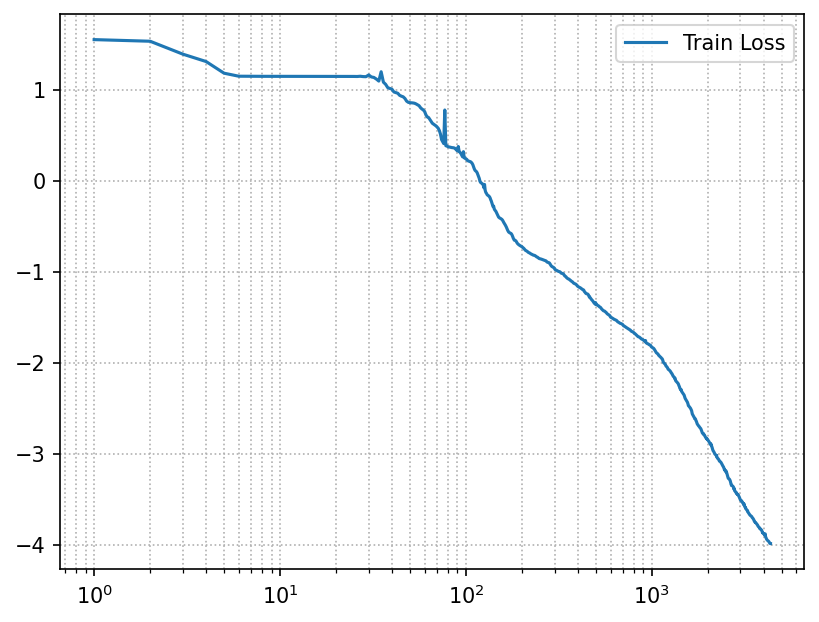

In [12]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

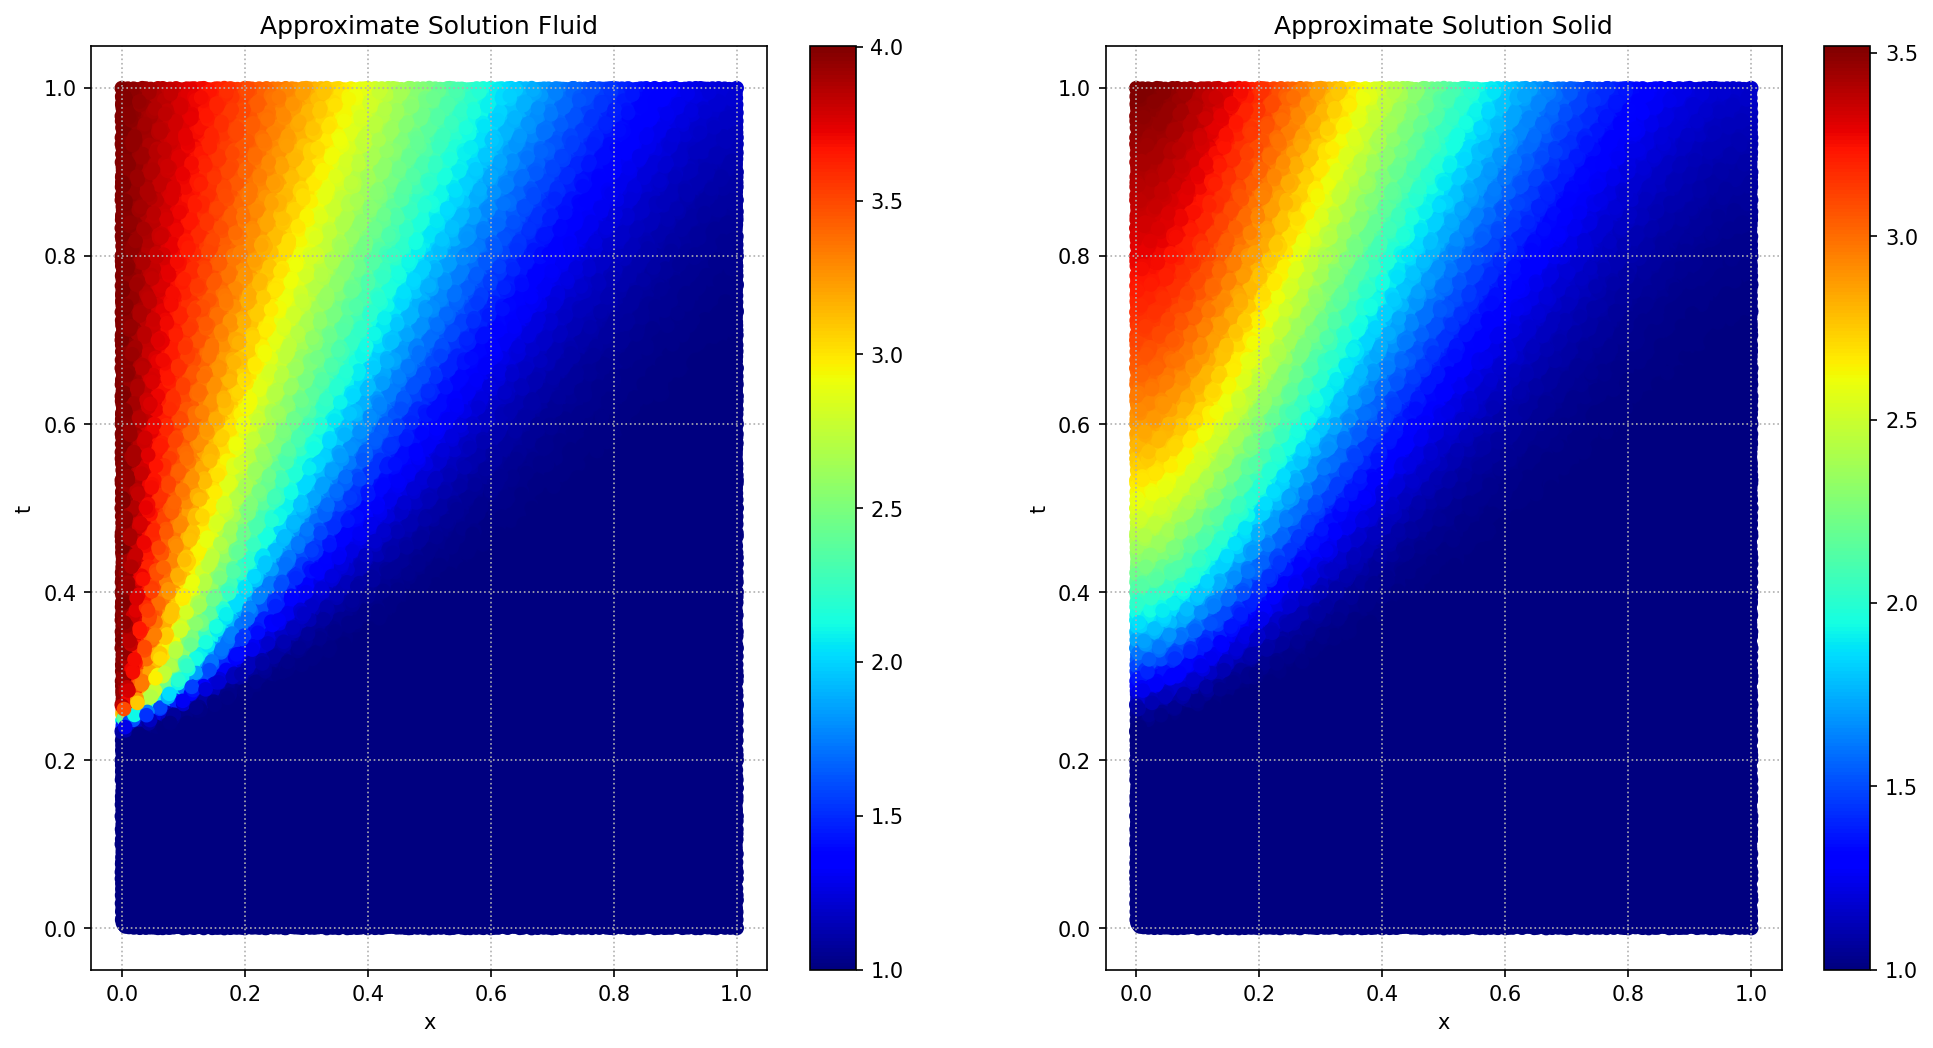

In [13]:
pinn.plot()

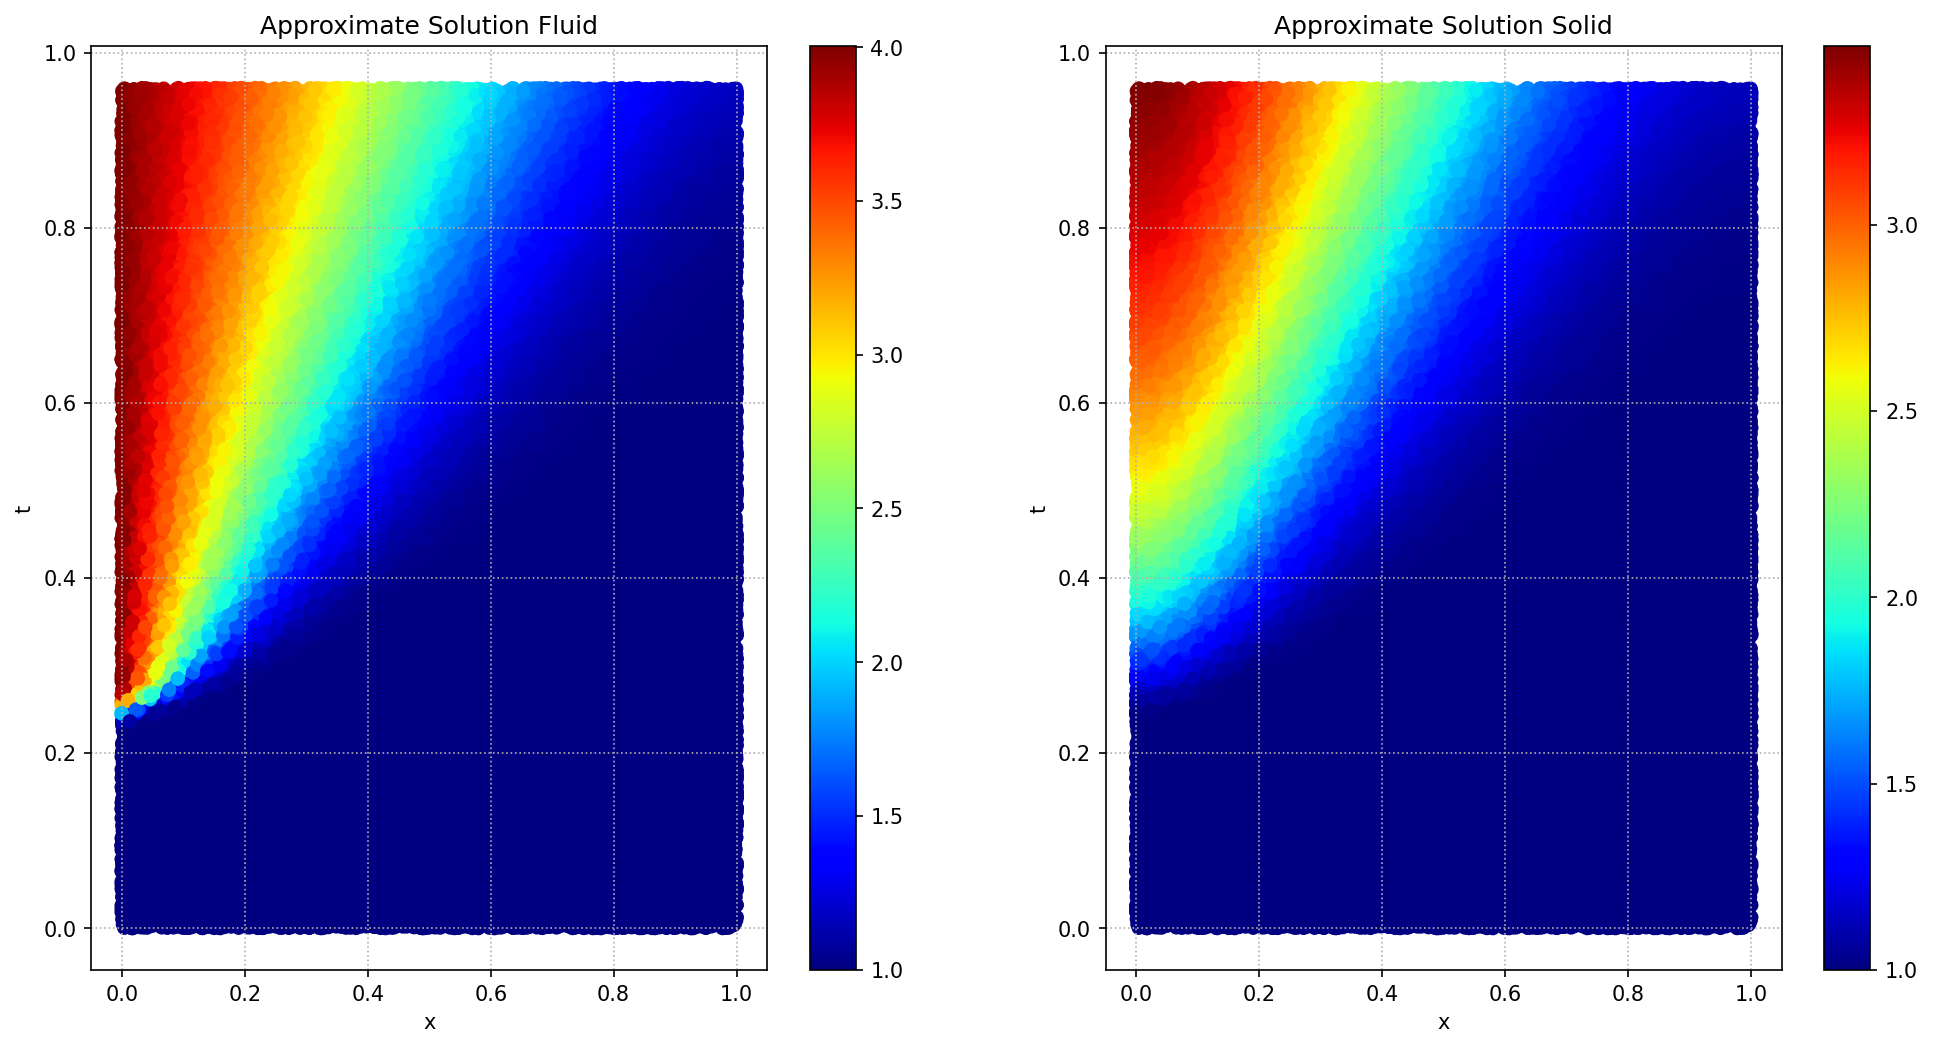

In [17]:
inputs = pinn.validation_ds.data_table
predictions = pinn.approximate_solution(inputs)

approx_Tf, approx_Ts = predictions[:,0], predictions[:,1]
# exact_output = self.exact_solution(inputs).reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(
    inputs[:, 1].detach(), inputs[:, 0].detach(),
    c=approx_Tf.detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(
    inputs[:, 1].detach(), inputs[:, 0].detach(), c=approx_Ts.detach(),
    cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution Fluid")
axs[1].set_title("Approximate Solution Solid")

# plt.show()
plt.savefig('predictions.png')

In [18]:
results = torch.concat([inputs, predictions], dim=1)
results = results.detach().numpy()
results = pd.DataFrame(results, columns=['t', 'x', 'tf', 'ts'])
results.to_csv('OutputTask1.txt', index=False)